In [1]:
#Importing libraries
import pandas as pd
import numpy as np
from scipy.optimize import fmin_slsqp
import matplotlib.pyplot as plt
import os
from pprint import pprint
import random

In [2]:
#Listing the existing files in the dir
for root, dirs, files in os.walk("."):  
    for filename in files:
        print(filename)

extract_data.ipynb
index.html
main.ipynb
code.ipynb
README.md
index
config
HEAD
packed-refs
description
pack-721345e10486339561905e530913e6b225017f25.idx
pack-721345e10486339561905e530913e6b225017f25.pack
exclude
HEAD
master
pre-commit.sample
pre-receive.sample
prepare-commit-msg.sample
commit-msg.sample
applypatch-msg.sample
post-update.sample
pre-rebase.sample
fsmonitor-watchman.sample
pre-push.sample
pre-applypatch.sample
update.sample
HEAD
HEAD
master
eco-cdmx.csv
test.mod
example1.csv
eco-amb.csv
eco-cdmx-labelled.xls
eco-amb-labelled.xls
code-checkpoint.ipynb
extract_data-checkpoint.ipynb
main-checkpoint.ipynb
data-2018-09-24.reduced.csv
output.csv
example.csv
data-2018-09-24.csv
1sherman_h_d_zhu_j_auth_service_productivity_management_impro.pdf


In [3]:
#Loading df
df = pd.read_csv('./files/data-2018-09-24.csv') #skiprows = 1)
df = df.drop(df.loc[:,['name', 'pft']].head(0).columns, axis=1)
df.head() #where xs are input vars and ys are output vars

,dmu,x1,x2,x3,x4,x5,y1,y2,y3
0,A,86.13,16.24,48.21,49.69,9,54.53,58.98,38.16
1,B,29.26,10.24,41.96,40.65,5,24.69,33.89,26.02
2,C,43.12,11.31,38.19,35.03,9,36.41,40.62,28.51
3,D,24.96,6.14,24.81,25.15,7,14.94,17.58,16.19
4,E,11.62,2.21,6.85,6.37,4,7.81,6.94,5.37


In [4]:
#Save input, output and unit as separate numpy arrays
inpt_df = df.iloc[:, 1:6]
inpt_arr = np.array(inpt_df)
outpt_df = df.iloc[:, 6:]
outpt_arr = np.array(outpt_df)
comp = np.array(df.iloc[:, 0])
print(inpt_arr, outpt_arr, comp)

[[86.13 16.24 48.21 49.69  9.  ]
 [29.26 10.24 41.96 40.65  5.  ]
 [43.12 11.31 38.19 35.03  9.  ]
 [24.96  6.14 24.81 25.15  7.  ]
 [11.62  2.21  6.85  6.37  4.  ]
 [11.88  4.97 18.73 18.04  4.  ]
 [32.64  6.88 28.1  25.45  7.  ]
 [20.79 12.97 54.85 52.07  8.  ]
 [34.4  11.04 38.16 42.4   8.  ]
 [61.74 14.5  49.09 42.92  9.  ]
 [52.92 11.67 39.48 39.64  5.  ]
 [36.   10.15 37.8  39.52  5.  ]
 [39.2  10.8  41.04 41.12  7.  ]
 [14.6   2.88  9.64 11.14  3.  ]
 [ 4.29  5.42 21.45 17.27  5.  ]
 [27.25 14.17 56.46 55.26  9.  ]
 [22.63  4.43 15.4  15.    2.  ]
 [28.    7.61 28.73 27.04  9.  ]
 [53.56 13.7  53.04 49.85  7.  ]
 [25.42  9.05 29.69 31.74  4.  ]
 [31.57 10.08 39.34 40.57  6.  ]
 [16.34  5.84 20.89 22.1   4.  ]
 [44.28 14.14 56.7  52.27 11.  ]
 [19.74  6.43 24.2  25.66  3.  ]
 [24.4   8.05 33.42 31.29  7.  ]
 [41.4  11.7  44.01 46.35  7.  ]] [[54.53 58.98 38.16]
 [24.69 33.89 26.02]
 [36.41 40.62 28.51]
 [14.94 17.58 16.19]
 [ 7.81  6.94  5.37]
 [12.59 16.85 12.84]
 [17.06 16.99 1

In [5]:
#Estimating efficient and non efficient units
class DEA(object):
    random.seed(5)
    def __init__(self, inputs, outputs):
        """
        Initialize the DEA object with input data
        n = number of entities (observations)
        m = number of inputs (variables, features)
        r = number of outputs
        :param inputs: inputs, n x m numpy array
        :param outputs: outputs, n x r numpy array
        :return: self
        """
        # supplied data
        self.inputs = inputs
        self.outputs = outputs
        # parameters
        self.n = inputs.shape[0]
        self.m = inputs.shape[1]
        self.r = outputs.shape[1]
        # iterators
        self.unit_ = range(self.n)
        self.input_ = range(self.m)
        self.output_ = range(self.r)
        # result arrays
        self.output_w = np.zeros((self.r, 1), dtype=np.float)  # output weights
        self.input_w = np.zeros((self.m, 1), dtype=np.float)  # input weights
        self.lambdas = np.zeros((self.n, 1), dtype=np.float)  # unit efficiencies
        self.efficiency = np.zeros_like(self.lambdas)  # thetas
        # names
        self.names = []

    def __efficiency(self, unit):
        """
        Efficiency function with already computed weights
        :param unit: which unit to compute for
        :return: efficiency
        """
        # compute efficiency
        denominator = np.dot(self.inputs, self.input_w)
        numerator = np.dot(self.outputs, self.output_w)
        return (numerator/denominator)[unit]

    def __target(self, x, unit):
        """
        Theta target function for one unit
        :param x: combined weights
        :param unit: which production unit to compute
        :return: theta
        """
        in_w, out_w, lambdas = x[:self.m], x[self.m:(self.m+self.r)], x[(self.m+self.r):]  # unroll the weights
        denominator = np.dot(self.inputs[unit], in_w)
        numerator = np.dot(self.outputs[unit], out_w)
        return numerator/denominator

    def __constraints(self, x, unit):
        """
        Constraints for optimization for one unit
        :param x: combined weights
        :param unit: which production unit to compute
        :return: array of constraints
        """
        in_w, out_w, lambdas = x[:self.m], x[self.m:(self.m+self.r)], x[(self.m+self.r):]  # unroll the weights
        constr = []  # init the constraint array
        # for each input, lambdas with inputs
        for input in self.input_:
            t = self.__target(x, unit)
            lhs = np.dot(self.inputs[:, input], lambdas)
            cons = t*self.inputs[unit, input] - lhs
            constr.append(cons)
        # for each output, lambdas with outputs
        for output in self.output_:
            lhs = np.dot(self.outputs[:, output], lambdas)
            cons = lhs - self.outputs[unit, output]
            constr.append(cons)
        # for each unit
        for u in self.unit_:
            constr.append(lambdas[u])
        return np.array(constr)

    def __optimize(self):
        """
        Optimization of the DEA model
        Use: http://docs.scipy.org/doc/scipy-0.17.0/reference/generated/scipy.optimize.linprog.html
        A = coefficients in the constraints
        b = rhs of constraints
        c = coefficients of the target function
        :return:
        """
        d0 = self.m + self.r + self.n
        # iterate over units
        for unit in self.unit_:
            # weights
            x0 = np.random.rand(d0) - 0.5
            x0 = fmin_slsqp(self.__target, x0, f_ieqcons=self.__constraints, args=(unit,))
            # unroll weights
            self.input_w, self.output_w, self.lambdas = x0[:self.m], x0[self.m:(self.m+self.r)], x0[(self.m+self.r):]
            self.efficiency[unit] = self.__efficiency(unit)

    def name_units(self, names):
        """
        Provide names for units for presentation purposes
        :param names: a list of names, equal in length to the number of units
        :return: nothing
        """
        assert(self.n == len(names))
        self.names = names

    def fit(self):
        global not_efficient, alls
        """
        Optimize the dataset, generate basic table
        :return: table
        """
        self.__optimize()  # optimize
        print("---------------------------\n")       

        efficient = {}
        not_efficient = {} 
        alls = {}
        for n, eff in enumerate(self.efficiency): 
            if eff >= 1.:
                efficient.update({self.names[n]: eff[0]}) 
            else:
                not_efficient.update({self.names[n]: eff[0]})
        for n, eff in enumerate(self.efficiency): 
            alls.update({self.names[n]: eff[0]})              
        print("Efficient units:")     
        print(str(efficient).replace("{","").replace("}", ""))       
        print("\n")    
        print("Inefficient units:")
        print(str(not_efficient).replace("{","").replace("}", ""))  

def save_results(dataframe):  
    df_results = pd.DataFrame([]) 
    df_results = df_results.append(not_efficient, ignore_index = True).T
    df_results = df_results.reset_index()
    df_results.columns = ['dmu', 'efficiency']    
    dataframe = dataframe.merge(df_results)
    return dataframe      

def save_results_complete(dataframe):    
    df_results_complete = pd.DataFrame([]) 
    df_results_complete = df_results_complete.append(alls, ignore_index = True).T
    df_results_complete = df_results_complete.reset_index()
    df_results_complete.columns = ['dmu', 'efficiency']    
    dataframe_complete = dataframe.merge(df_results_complete)
    return dataframe_complete        

dea = DEA(inpt_arr, outpt_arr)
dea.name_units(comp)
dea.fit()

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1.000000000000331
            Iterations: 11
            Function evaluations: 397
            Gradient evaluations: 11
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.9663164619585765
            Iterations: 14
            Function evaluations: 505
            Gradient evaluations: 14
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.9958121448127505
            Iterations: 16
            Function evaluations: 577
            Gradient evaluations: 16
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.9321406284238705
            Iterations: 13
            Function evaluations: 468
            Gradient evaluations: 13
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1.0000000000267368
            Iterations: 7
            Funct

In [8]:
df_ineff = save_results(df)
df_complete = save_results_complete(df)
df_complete.head()

,dmu,x1,x2,x3,x4,x5,y1,y2,y3,efficiency
0,A,86.13,16.24,48.21,49.69,9,54.53,58.98,38.16,1.000000
1,B,29.26,10.24,41.96,40.65,5,24.69,33.89,26.02,0.966316
2,C,43.12,11.31,38.19,35.03,9,36.41,40.62,28.51,0.995812
3,D,24.96,6.14,24.81,25.15,7,14.94,17.58,16.19,0.932141
4,E,11.62,2.21,6.85,6.37,4,7.81,6.94,5.37,1.000000


In [9]:
#Estimating the improvement options - input oriented
heading = list(df_ineff.iloc[:, 1:6])

inter = []
for c in df_ineff.iloc[:, 1:6].columns:
    inter.append(df_ineff[c].multiply((1- df_ineff.iloc[:,-1])))
    df_improvement = round(pd.concat(inter, axis = 1),1)
    df_improvement = df_improvement.rename(columns = dict(zip(df_improvement.columns, heading)))
df_improvement  = pd.concat([df_improvement,df_ineff[['dmu']]], axis = 1)
df_improvement.head()

,x1,x2,x3,x4,x5,dmu
0,1.0,0.3,1.4,1.4,0.2,B
1,0.2,0.0,0.2,0.1,0.0,C
2,1.7,0.4,1.7,1.7,0.5,D
3,0.8,0.4,1.3,1.3,0.3,F
4,2.5,0.5,2.2,2.0,0.5,G


In [10]:
#Estimating the improvement options - output oriented
heading_output = list(df.iloc[:, 6:9])

inter_out = []
for c in df.iloc[:, 6:9].columns:
    inter_out.append(df[c].multiply((1- df.iloc[:,-1])/df.iloc[:,-1]).add(df[c]))
    df_improvement_outpt = round(pd.concat(inter_out, axis = 1),1)
    df_improvement_outpt = df_improvement_outpt.rename(columns = dict(zip(df_improvement_outpt.columns, heading_output)))
df_improvement_outpt  = pd.concat([df_improvement_outpt,df[['dmu']]], axis = 1)
df_improvement_outpt.head()

,y1,y2,y3,dmu
0,1.4,1.5,1.0,A
1,0.9,1.3,1.0,B
2,1.3,1.4,1.0,C
3,0.9,1.1,1.0,D
4,1.5,1.3,1.0,E


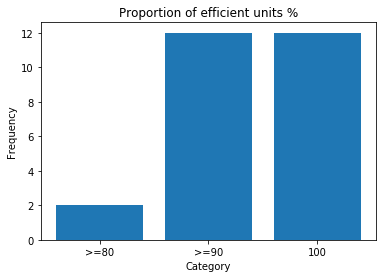

In [11]:
#Assigning lables depending on the efficiency score
def classification(x):
    """The function assings lables depending on the efficiency score a unit falls into"""
    for u in x:
        if u >= 1.0 : return '100'
        elif u >= 0.9: return '>=90'
        elif u >= 0.8: return '>=80'
        elif u >= 0.7: return '>=70'
        elif u >= 0.6: return '>=60'
        elif u >=0.5: return '>=50'
        elif u >=0.4: return '>=40'
        elif u >= 0.3: return '>=0.3'
        else: return '<0.3'
df_complete['category'] =  df_complete[['efficiency']].apply(classification, axis = 1)

#Creating the frequency table
df_freq = df_complete.groupby('category').count().reset_index()
categories = ['>=80', '>=90', '100']
#Ploting the distribution graph
mapping = {category: i for i, category in enumerate(categories)}
key = df_freq['category'].map(mapping)    
df_freq = df_freq.iloc[key.argsort()]

# Draw the bar chart
plt.bar(df_freq['category'], df_freq['efficiency'], tick_label=categories)
plt.title('Proportion of efficient units %')
plt.ylabel('Frequency')
plt.xlabel('Category')
plt.show()